In [1]:
import pandas as pd
import os.path as osp
from configuration import Config
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import json
import numpy as np
import os


config = Config()

In [2]:
grid_data = pd.read_json(osp.join(config.data_dir, "color_grid_data.json"))
patch_data = pd.read_json(osp.join(config.data_dir, "color_patch_data.json"))

In [3]:
def has_listener_utt(utts):
    interlocutors = [il for il, ut, _ in utts]
    return 'listener' in interlocutors

def parse_patch_results(data):

    # load data
    data_df = pd.read_json(
        osp.join(config.data_dir, 'color_patch_data.json'))
    data_df = data_df.rename(columns={
        'success': 'human_success'
    })

    # load results
    results_df = pd.DataFrame(data)

    merge_cols = [c for c in data_df.columns if c == 'identifier' or c not in results_df.columns]

    # merge dfs
    results_df = pd.merge(
        results_df, data_df[merge_cols],
        left_on=['identifier'],
        right_on=['identifier']
    )

    # check if there are listener utterances
    results_df['has_listener_utt'] = results_df.conversation.map(has_listener_utt)

    return results_df


def parse_grid_results(data):

    # load data
    data_df = pd.read_json(
        osp.join(config.data_dir, 'color_grid_data.json'))
    data_df = data_df.rename(columns={
        'success': 'human_success'
    })

    # load results
    results_df = pd.DataFrame(data)

    # merge dfs
    merge_cols = [
        'gameid', 'roundNum', 'human_success', 'utterances', 
        'n_utterances', 'objs', 'target', 
        'speaker_order', 'listener_order', 'listener_clicked'
    ]
    results_df = pd.merge(
        results_df, data_df[merge_cols],
        left_on=['gameid', 'roundNum'],
        right_on=['gameid', 'roundNum']
    )

    # check if there are listener utterances
    results_df['has_listener_utt'] = results_df.utterances.map(has_listener_utt)

    return results_df

def parse_results(path):
    
    with open(path, 'r') as f:
        data = json.load(f)
        results_config = data['config']
        results_data = data['results']

    if results_config['task'] == 'grid':
        return results_config, parse_grid_results(results_data)
    else:
        return results_config, parse_patch_results(results_data)

In [4]:
# read and parse inputs
results_files = glob(osp.join(config.output_dir, '*.json'))
all_results = [parse_results(f) for f in results_files]

In [5]:
results_dict = defaultdict(dict)

for r_config, df in all_results:

    model_type = r_config['model_type']
    model_size = int(r_config['model_size'].replace('b', ''))
    task = r_config['task']
    quant = r_config['quant']

    results_dict[f'{model_type}-{model_size}-{task}']['system'] = model_type
    results_dict[f'{model_type}-{model_size}-{task}']['size'] = model_size
    results_dict[f'{model_type}-{model_size}-{task}']['task'] = task
    results_dict[f'{model_type}-{model_size}-{task}']['quant'] = quant
    
    # total accuracy
    results_dict[f'{model_type}-{model_size}-{task}']['total_acc'] = df.correct.mean()

    # accuracy per condition
    per_condition_results = df.groupby('condition').correct.mean().to_dict()
    results_dict[f'{model_type}-{model_size}-{task}'].update(
        {f'{k.lower()}_acc':v for k,v in per_condition_results.items()}
    )
    
    # predicted locations
    pred_locations = (df.groupby('predicted_location').size() / len(df)).rename({'None': 'unknown'}).to_dict()
    results_dict[f'{model_type}-{model_size}-{task}'].update(
        {f'{d}_ratio':pred_locations.get(d, 0) for d in ['left', 'middle', 'right', 'unknown']}
    )

results_df = pd.DataFrame(results_dict).T
acc_cols = [c for c in results_df.columns if 'acc' in c]
results_df[acc_cols] = results_df[acc_cols].astype(float) * 100  # convert to %

# Accuracy Scores (Table 1)

In [6]:
display_df = True
print_latex = True
print_str = True

acc_cols = ['total', 'far', 'split', 'close']
    
r = results_df.sort_index()
task_dfs = []

for task in ['patch', 'grid']:
    #print('\n', task.upper(), '#'*50, sep='\n')
    _r = r.loc[r.task == task].sort_values(by=['system', 'size']).drop(columns=['task'])
    rename = {c:c.replace('_acc', '') for c in _r.columns}
    _r = _r.set_index(['system', 'size', 'quant']).rename(columns=rename)[acc_cols]

    # add scores for humans
    data = grid_data if task == 'grid' else patch_data
    human_per_condition = data.groupby('condition').success.mean()
    human_per_condition.index = human_per_condition.index.map(str.lower)
    human_per_condition['total'] = data.success.mean()
    human_per_condition = human_per_condition * 100
    _r.loc['human', -1, '-'] = human_per_condition
    
    multicolumns=[(task, c) for c in _r.columns]
    _r.columns=pd.MultiIndex.from_tuples(multicolumns)
        
    task_dfs.append(_r)
    
merged_results = pd.concat(task_dfs, axis=1).sort_index(ascending=[True, True, True])

m = pd.DataFrame(index=merged_results.index,columns=merged_results.columns)
m.iloc[:-1] = True
m.iloc[-1] = False

style_idx = pd.IndexSlice[merged_results.index[:-1], :]

if display_df:
    display(merged_results.style.highlight_max(subset=style_idx, axis=0, props="font-weight:bold;").format(precision=1))    
if print_latex:
    print(merged_results.style.highlight_max(subset=style_idx, axis=0, props="textbf:--rwrap;").format(precision=1).to_latex())
if print_str:
    print(merged_results.round(1).to_string())

\begin{tabular}{lllrrrrrrrr}
 &  &  & \multicolumn{4}{r}{patch} & \multicolumn{4}{r}{grid} \\
 &  &  & total & far & split & close & total & far & split & close \\
system & size & quant &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{Janus} & 1 & nan & 36.1 & 38.1 & 35.4 & 34.8 & 33.3 & 33.2 & 33.4 & 33.3 \\
 & 7 & nan & 68.4 & 83.9 & 64.4 & 56.8 & 39.5 & 41.1 & 38.7 & 38.7 \\
\multirow[c]{4}{*}{LLaVa} & 7 & nan & 60.1 & 71.4 & 59.1 & 49.5 & 38.0 & 38.6 & 38.7 & 36.8 \\
 & 13 & nan & 59.4 & 70.0 & 57.8 & 50.4 & 37.7 & 38.3 & 37.9 & 36.8 \\
 & 34 & nan & 80.3 & 93.1 & 77.4 & 70.2 & 37.9 & 38.8 & 38.2 & 36.6 \\
 & 72 & 8bit & 62.3 & 75.8 & 59.9 & 51.2 & 39.9 & 42.0 & 40.2 & 37.6 \\
\multirow[c]{3}{*}{Qwen} & 2 & nan & 61.9 & 77.3 & 58.3 & 50.0 & 38.4 & 40.0 & 38.3 & 36.8 \\
 & 7 & nan & 83.0 & 94.1 & 81.1 & 73.8 & 45.2 & 47.7 & 44.4 & 43.4 \\
 & 72 & awq & \textbf{87.5} & \textbf{95.1} & \textbf{86.9} & \textbf{80.3} & \textbf{66.5} & \textbf{70.2} & \textbf{66.0} & \textbf{63.2} \\
human 

In [ ]:
table_out_dir = osp.abspath('./generated_tables/')
if not osp.isdir(table_out_dir):
    print(f'make new dir: {table_out_dir}')
    os.makedirs(table_out_dir)

fname = 'results_general.csv'
fpath = osp.join(table_out_dir, fname)
print(f'save table to {fpath}')
merged_results.to_csv(fpath)

# Location Biases (Figure 2)

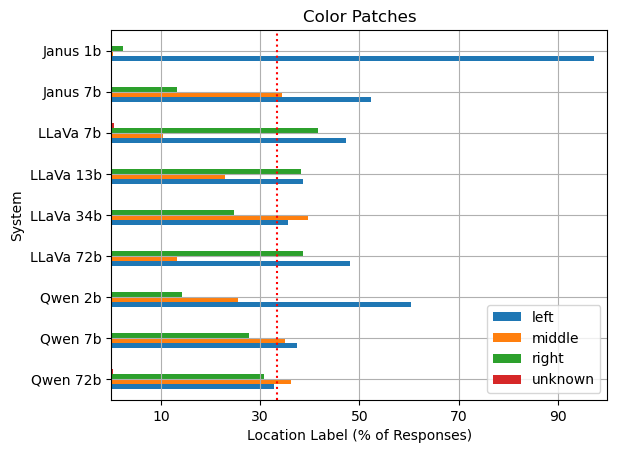

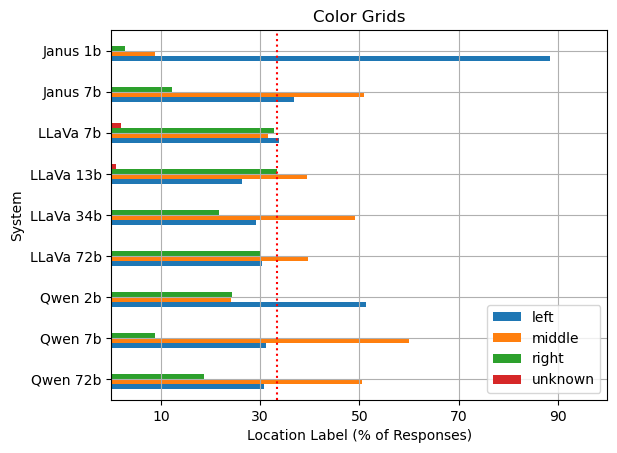

In [8]:
def format_model_name(name):
    name = name.replace('-patch', '').replace('-grid', '')
    name = name.replace('-', ' ') + 'b'
    return name

model_rename = {m:format_model_name(m) for m in results_df.index}

col_rename = {
    'unknown_ratio': 'unknown',
    'left_ratio': 'left',
    'middle_ratio': 'middle',
    'right_ratio': 'right',
}


for task in 'patch', 'grid':    
    _r = results_df.loc[results_df.task == task] * 100
    _r = _r.sort_values(by=['system', 'size', 'task'])[['left_ratio', 'middle_ratio', 'right_ratio', 'unknown_ratio']]
    _r = _r.rename(columns=col_rename, index=model_rename).iloc[::-1]
    _r.plot(kind='barh')
    #plt.xticks(rotation=90)
    plt.xticks(ticks=[10,30,50,70,90])
    plt.title(f'Color {"Patches" if task == "patch" else "Grids"}')
    plt.xlim(0,100)
    plt.axvline(x=1/3 * 100, color='red', linestyle='dotted')
    plt.ylabel('System')
    plt.xlabel('Location Label (% of Responses)')
    plt.grid()
    plt.show()